# 1. <a id='toc1_'></a>[Определение стоимости автомобилей](#toc0_)

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Содержание**<a id='toc0_'></a>    
- 1. [Определение стоимости автомобилей](#toc1_)    
  - 1.1. [Подготовка данных](#toc1_1_)    
      - 1.1.1.1. [План предобработки:](#toc1_1_1_1_)    
      - 1.1.1.2. [Посмотрим уникальные значения](#toc1_1_1_2_)    
      - 1.1.1.3. [Посмотрим корреляцию на числовых параметрах](#toc1_1_1_3_)    
      - 1.1.1.4. [Определим колонки которые необходимо удалить или заменить значения](#toc1_1_1_4_)    
      - 1.1.1.5. [Смотрим пропуски](#toc1_1_1_5_)    
      - 1.1.1.6. [Проведём порядковое кодирование признаков](#toc1_1_1_6_)    
      - 1.1.1.7. [Объединяем параметры после порядкового кодирования с другими признаками](#toc1_1_1_7_)    
    - 1.1.2. [ИАД](#toc1_1_2_)    
    - 1.1.3. [Проверим какие параметры коррелируют с целевым признаком](#toc1_1_3_)    
  - 1.2. [Обучение моделей](#toc1_2_)    
  - 1.3. [Анализ моделей](#toc1_3_)    
    - 1.3.1. [Проверка лучшей модели `CatBoost` на тестовой выборке](#toc1_3_1_)    
  - 1.4. [Чек-лист проверки](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[Подготовка данных](#toc0_)

Устанавливаем дополнительные библиотеки

In [1]:
# LightGBM
%pip install lightgbm
# CatBoost
%pip install catboost


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: catboost in c:\users\asus\anaconda3\lib\site-packages (1.1.1)



Импортируем библиотеки согласно стандарту PEP-8

In [2]:
# стандартные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# сторонние библиотеки
import catboost as cb
from catboost import CatBoostRegressor
from itertools import product
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Загружаем данные

In [3]:
%%time
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

CPU times: total: 1.03 s
Wall time: 1.12 s


Признаки <br>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Выводим основную информацию для каждого региона.
Для оптимизации кода создаём функцию `show_i()` принимающую как аргумент датафрейм и выводящую на экран необходимую информацию.

In [4]:
def show_i(data):

    '''Выводим на экран следущую информацию:

    - размер таблицы
    - основную информацию
    - первые 5 строк таблицы
    - суммарная статистика по числовым параметрам
    - суммарная статистика по нечисловым параметрам'''

    display(data.shape)
    display(data.info())
    display(data.head())
    display(data.describe())
    display(data.describe(include=['O']))

In [5]:
show_i(df)

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


#### 1.1.1.1. <a id='toc1_1_1_1_'></a>[План предобработки:](#toc0_)

- ищем уникальные значения, удаляем выбросы
- ищем пропуски и заполняем или удаляем их
- меняем тип признаков если необходимо

#### 1.1.1.2. <a id='toc1_1_1_2_'></a>[Посмотрим уникальные значения](#toc0_)

In [6]:
print(df.VehicleType.unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [7]:
print(df.Gearbox .unique())

['manual' 'auto' nan]


In [8]:
print(df.FuelType.unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [9]:
print(df.Repaired.unique())

[nan 'yes' 'no']


In [10]:
print(df.NumberOfPictures.unique())

[0]


In [11]:
np.sort(df.RegistrationYear.unique())[:]

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

#### 1.1.1.3. <a id='toc1_1_1_3_'></a>[Посмотрим корреляцию на числовых параметрах](#toc0_)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\471703260.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='spearman')


<Axes: >

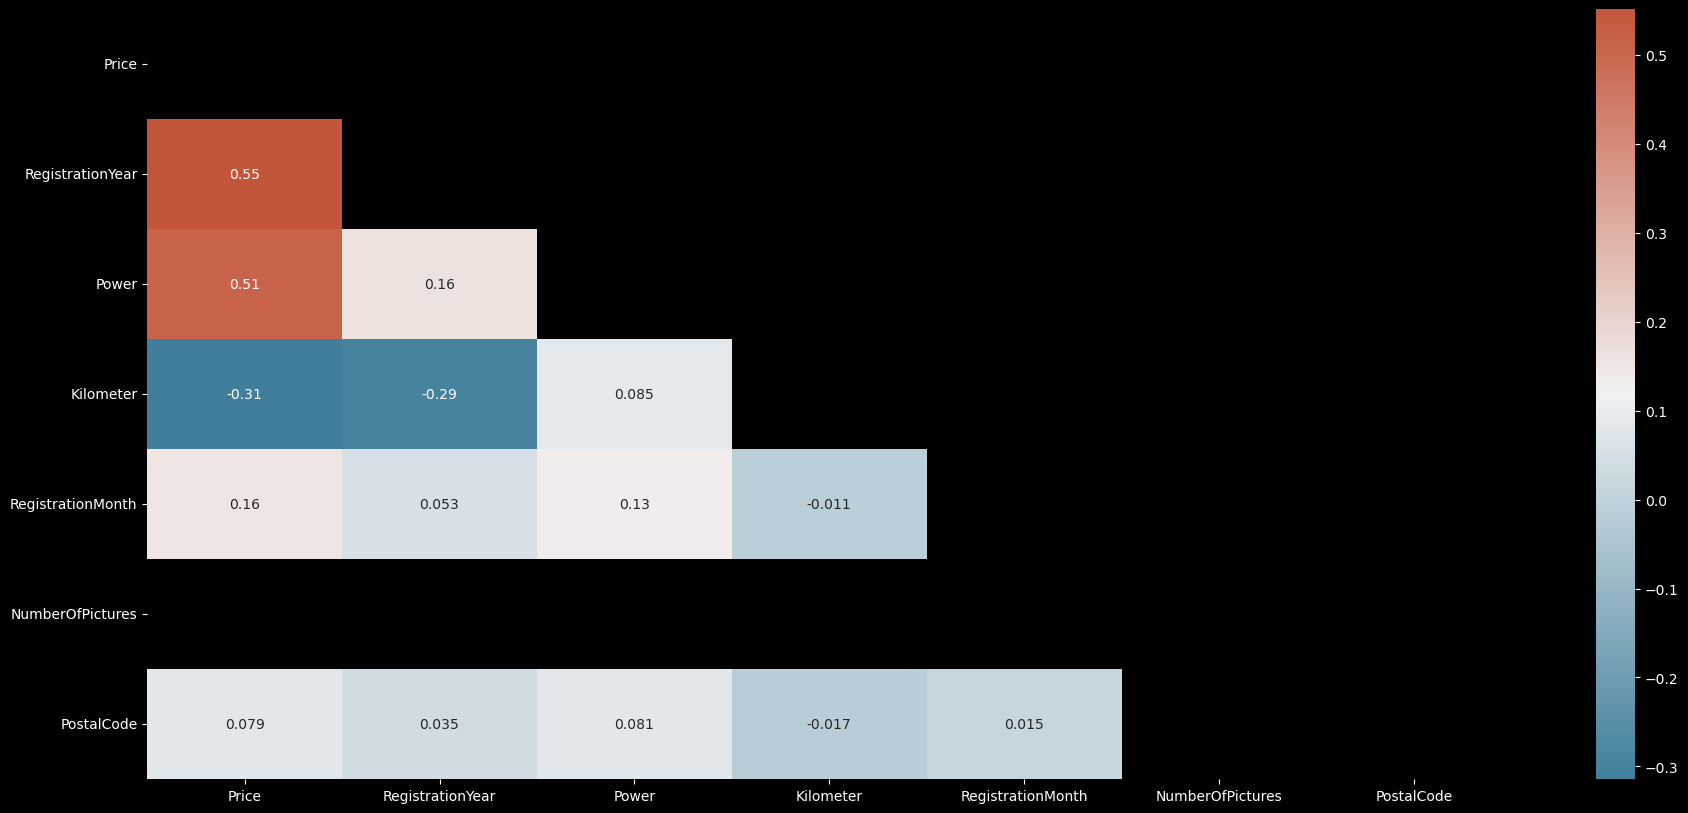

In [12]:
# корреляция по df

# корреляция между разными значениями
corr = df.corr(method='spearman')

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(22, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

#plt.show

#### 1.1.1.4. <a id='toc1_1_1_4_'></a>[Определим колонки которые необходимо удалить или заменить значения](#toc0_)

- DateCrawled - Дата скачивание анкеты из базы, абстрактная информация не имеющая отношение к целевому признаку.
- VehicleType - стоит указать пропущенные значения как "другие" (other)
- Gearbox - сложно заполнить его данными, поетому пропуски заполню категорией 'other'
- Model - найти пропущенные данные о модели сложно, поетому заполним как 'other' 
- FuelType - пропущенные данны придётся обозначить как 'other'
- NumberOfPictures - имеет только нулевые значения, надо удалить
- DateCreated - не имеет отношения к цене
- PostalCode — почтовый индекс владельца анкеты (пользователя), не имеет отношения к автомобилю и цене, удалим
- LastSeen - не имее отношения к цене, кдалим эту колонку
- RegistrationYear - имеет большой разброс, имеет смысл сконцентрироваться на годах регистрации авто с 1990 по 2023 гг. Остальные значения удалим

#### 1.1.1.5. <a id='toc1_1_1_5_'></a>[Смотрим пропуски](#toc0_)

In [13]:
# пропуски в процентах (%)
display(pd.DataFrame(round(df.isna().mean()*100)).astype(int).style.background_gradient('coolwarm'))

,0
DateCrawled,0
Price,0
VehicleType,11
RegistrationYear,0
Gearbox,6
Power,0
Model,6
Kilometer,0
RegistrationMonth,0
FuelType,9


In [14]:
# пропуски в абсолютных значениях
display(pd.DataFrame(df.isna().mean()*df.shape[0]).astype(int).style.background_gradient('coolwarm'))

,0
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


In [15]:
# удаляем ненужные колонки не влияющие на целевой признак
df = df.drop('DateCrawled', axis = 1)
df = df.drop('NumberOfPictures', axis = 1)
df = df.drop('PostalCode', axis = 1)
df = df.drop('LastSeen', axis = 1)
df = df.drop('DateCreated', axis = 1)

In [16]:
# фильтруем неадекватные значенияю Оставляем машины с мощностью более 40 л.с.
df = df.loc[(df['Power'] > 40)]

In [17]:
# заменим пропущенные значения на 'other', а отсутствие информации о ремонте отметим 'unknown'
df.VehicleType = df['VehicleType'].fillna(value = 'other')
df.Gearbox = df['Gearbox'].fillna(value = 'other')
df.FuelType = df['FuelType'].fillna(value = 'other')
df.Repaired = df['Repaired'].fillna(value = 'unknown')
df.Model = df['Model'].fillna(value = 'other')

In [18]:
# оставляем машины зарегистрированные только в промежутке 1990-2016 гг. (дата скачивания анкеты 2016 г.)
df = df.loc[(df['RegistrationYear'] > 1990) & (df['RegistrationYear'] < 2016)]

# проверяем изменения
np.sort(df.RegistrationYear.unique())[:]

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015], dtype=int64)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> исправил недочёт
</div>

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: поменял верхнюю грницу с 2023 г. на 2016 г. чтобы год реистрации соответствовал дате скачивания анкеты.
</div>

In [19]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [20]:
df.RegistrationYear.unique()

array([2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009, 2002,
       1997, 2003, 1991, 2006, 1999, 2012, 1994, 2010, 2000, 1992, 2013,
       1996, 2015, 1993], dtype=int64)

#### 1.1.1.6. <a id='toc1_1_1_6_'></a>[Проведём порядковое кодирование признаков](#toc0_)

In [21]:
# создаём таблицу с призаками для кодирования
to_encode = df.drop(['Price', 'Power', 'Kilometer', 'RegistrationMonth'], axis=1)

In [22]:
to_encode.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType',
       'Brand', 'Repaired'],
      dtype='object')

Кодируем категориальные признаки числовыми начениями

In [23]:
encoder = OrdinalEncoder()
encoder.fit(to_encode)
encoded_df = pd.DataFrame(encoder.fit_transform(to_encode), columns=to_encode.columns)

In [24]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [25]:
encoded_df


,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,Repaired
0,2.0,20.0,1.0,166.0,2.0,1.0,2.0
1,6.0,13.0,0.0,117.0,2.0,14.0,1.0
2,5.0,10.0,1.0,116.0,6.0,38.0,0.0
3,5.0,17.0,1.0,101.0,2.0,31.0,0.0
4,4.0,4.0,1.0,11.0,6.0,2.0,2.0
...,...,...,...,...,...,...,...
286457,4.0,19.0,1.0,116.0,2.0,38.0,0.0
286458,4.0,13.0,1.0,140.0,6.0,30.0,2.0
286459,1.0,9.0,0.0,106.0,6.0,32.0,0.0
286460,0.0,5.0,1.0,221.0,2.0,38.0,0.0


#### 1.1.1.7. <a id='toc1_1_1_7_'></a>[Объединяем параметры после порядкового кодирования с другими признаками](#toc0_)

In [26]:
encoded_df = pd.concat([pd.DataFrame(encoded_df, columns=to_encode.columns), 
                        df.reset_index(drop=True)[['Price', 'Power', 'Kilometer', 'RegistrationMonth']]], axis=1)

In [27]:
encoded_df

,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,Repaired,Price,Power,Kilometer,RegistrationMonth
0,2.0,20.0,1.0,166.0,2.0,1.0,2.0,18300,190,125000,5
1,6.0,13.0,0.0,117.0,2.0,14.0,1.0,9800,163,125000,8
2,5.0,10.0,1.0,116.0,6.0,38.0,0.0,1500,75,150000,6
3,5.0,17.0,1.0,101.0,2.0,31.0,0.0,3600,69,90000,7
4,4.0,4.0,1.0,11.0,6.0,2.0,2.0,650,102,150000,10
...,...,...,...,...,...,...,...,...,...,...,...
286457,4.0,19.0,1.0,116.0,2.0,38.0,0.0,7900,140,150000,7
286458,4.0,13.0,1.0,140.0,6.0,30.0,2.0,3200,225,150000,5
286459,1.0,9.0,0.0,106.0,6.0,32.0,0.0,1199,101,125000,3
286460,0.0,5.0,1.0,221.0,2.0,38.0,0.0,9200,102,150000,3


In [28]:
# пропуски в абсолютных значениях
display(pd.DataFrame(encoded_df.isna().mean()*encoded_df.shape[0]).astype(int).style.background_gradient('coolwarm'))

,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Model,0
FuelType,0
Brand,0
Repaired,0
Price,0
Power,0
Kilometer,0


### 1.1.2. <a id='toc1_1_2_'></a>[ИАД](#toc0_)

### 1.1.3. <a id='toc1_1_3_'></a>[Проверим какие параметры коррелируют с целевым признаком](#toc0_)

<Axes: >

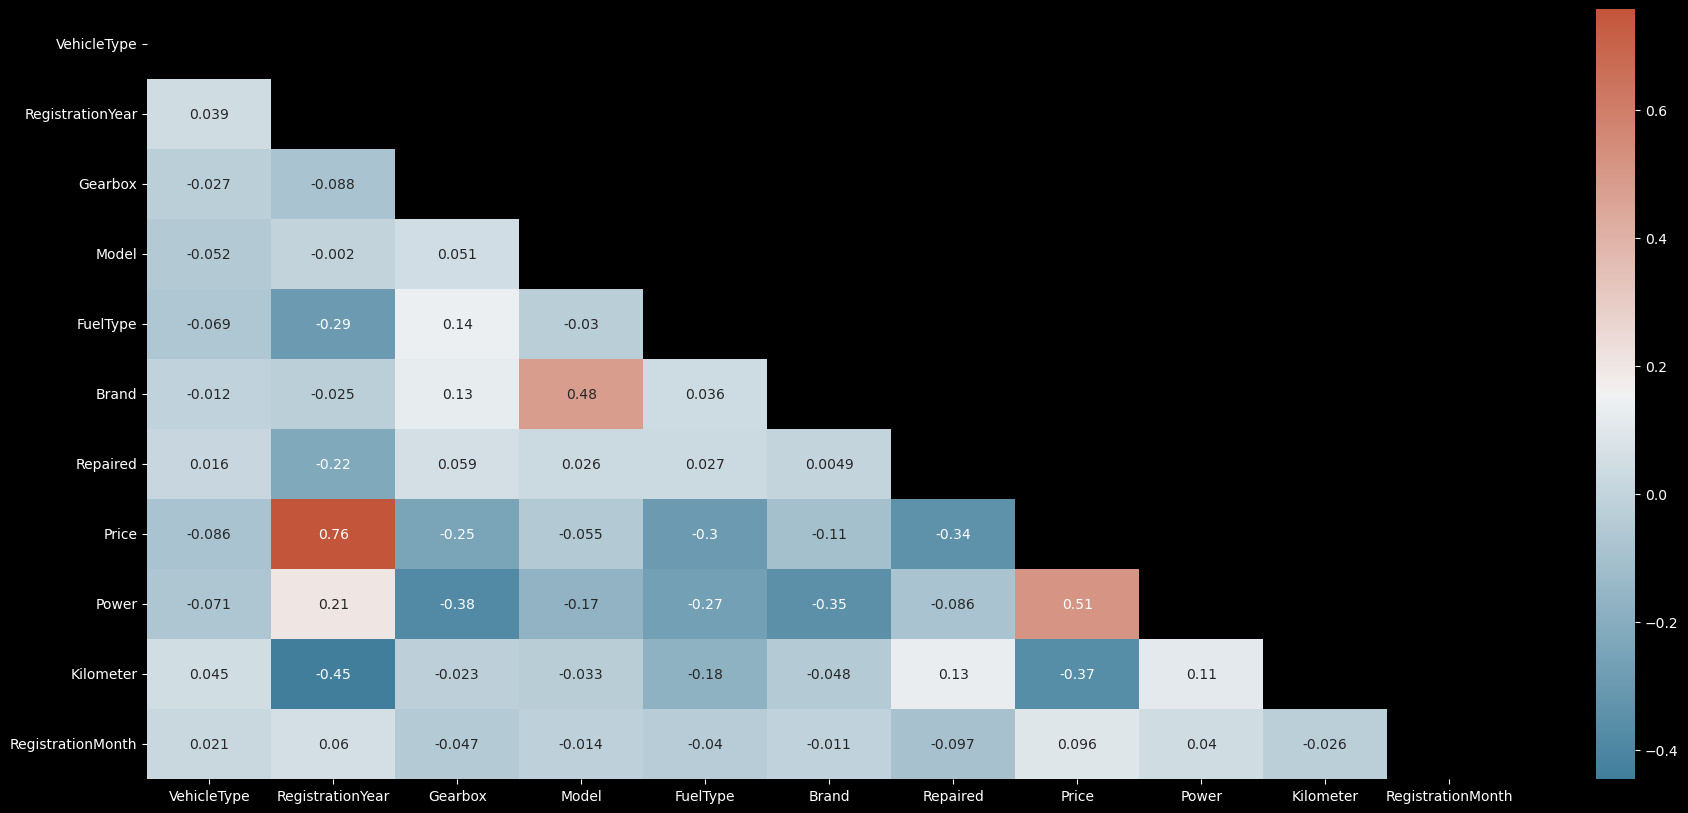

In [29]:
# корреляция между разными значениями
corr = encoded_df.corr(method='spearman')

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(22, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

Посмотрим на признаки по отдельности

In [30]:
# создадим функцию для просмотра каждого параметра в отдельности
def graph(data, title):
    plt.figure(figsize=(15,4))
    plt.title(title, fontsize=15)
    sns.distplot(data)
    sns.set(style='dark')
    plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\3049329969.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)


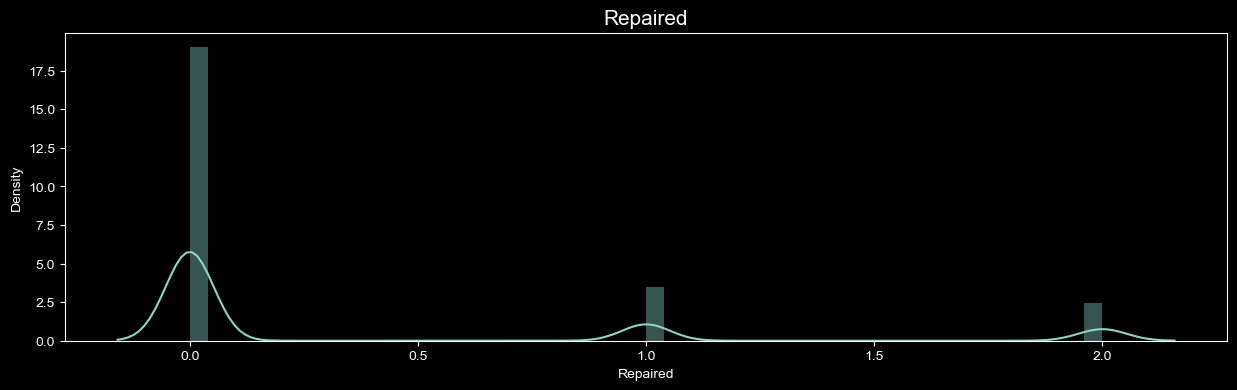

In [31]:
graph(encoded_df.Repaired, 'Repaired')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\3049329969.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)


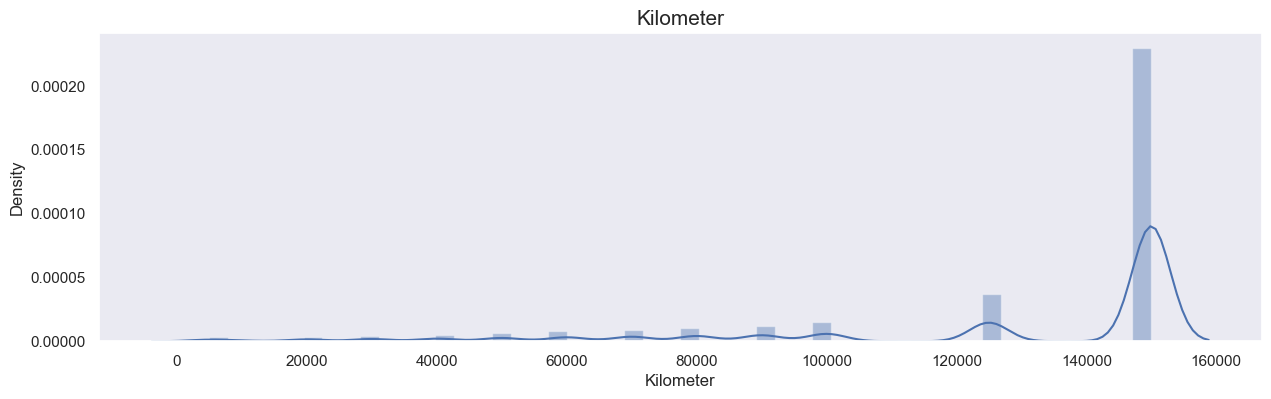

In [32]:
graph(encoded_df.Kilometer, 'Kilometer')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\3049329969.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)


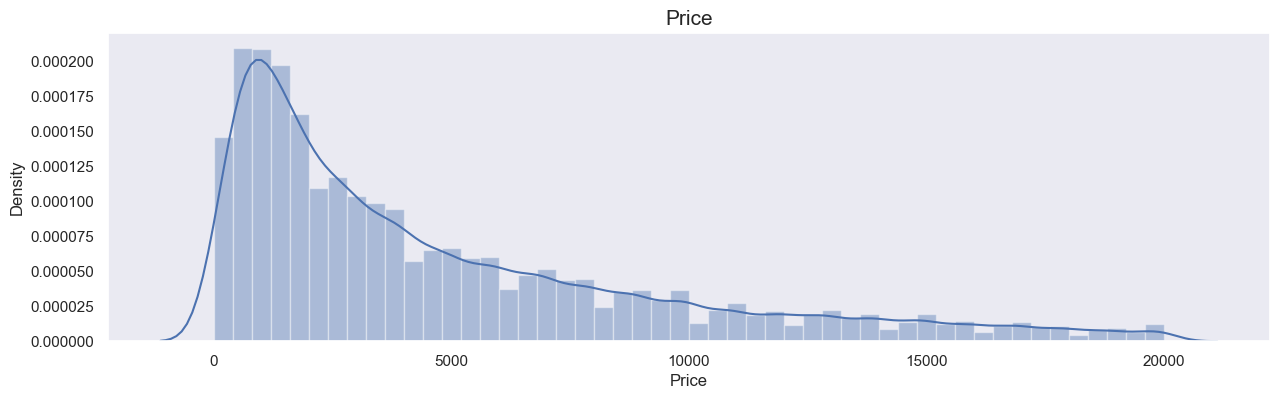

In [33]:
graph(encoded_df.Price, 'Price')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\3049329969.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)


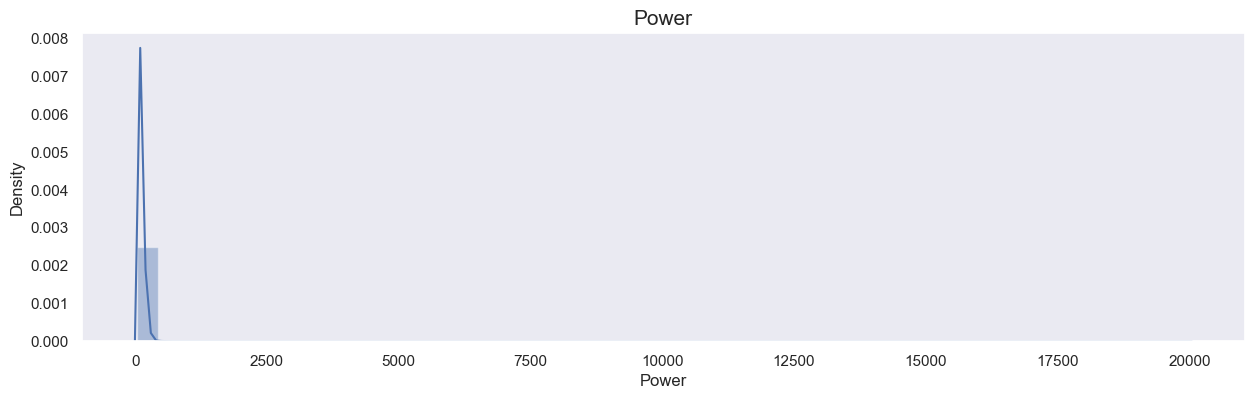

In [34]:
graph(encoded_df.Power, 'Power')

Мы видим что распределение мощностей имеет потенциальные выбросы. Проверим данные на выбросы

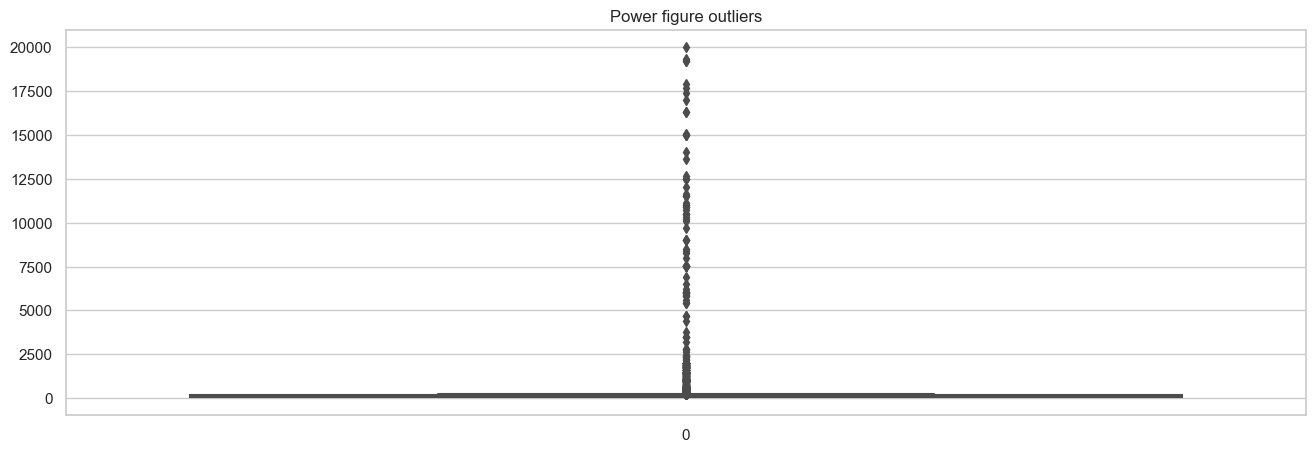

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
sns.boxplot(encoded_df.Power)
plt.title('Power figure outliers')
plt.show()

In [36]:
# фильтруем неадекватные значенияю Оставляем машины с мощностью менее 250 л.с.
encoded_df = encoded_df.loc[(encoded_df['Power'] < 250)]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6892\3049329969.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data)


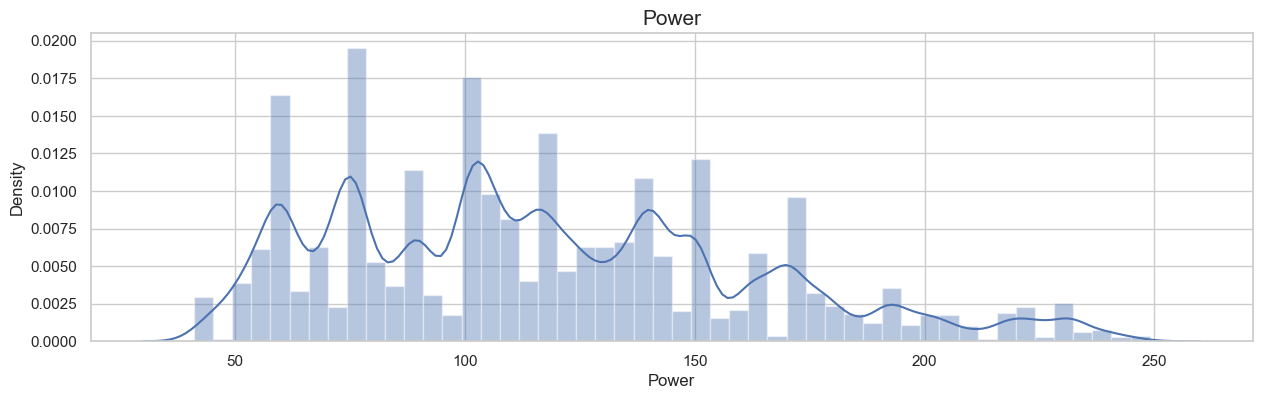

In [37]:
graph(encoded_df.Power, 'Power')

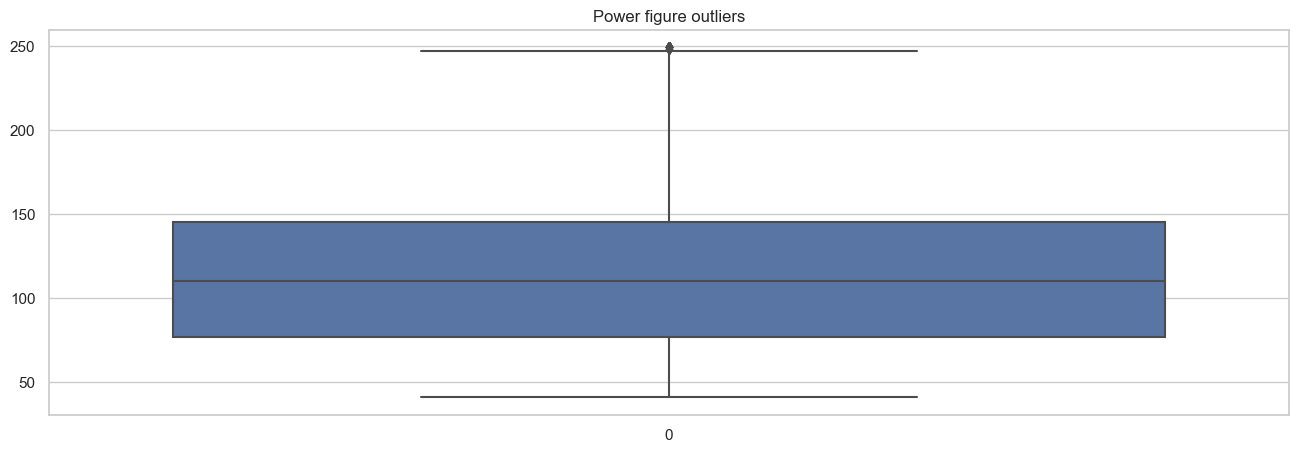

In [38]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
sns.boxplot(encoded_df.Power)
plt.title('Power figure outliers')
plt.show()

In [39]:
encoded_df

,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,Repaired,Price,Power,Kilometer,RegistrationMonth
0,2.0,20.0,1.0,166.0,2.0,1.0,2.0,18300,190,125000,5
1,6.0,13.0,0.0,117.0,2.0,14.0,1.0,9800,163,125000,8
2,5.0,10.0,1.0,116.0,6.0,38.0,0.0,1500,75,150000,6
3,5.0,17.0,1.0,101.0,2.0,31.0,0.0,3600,69,90000,7
4,4.0,4.0,1.0,11.0,6.0,2.0,2.0,650,102,150000,10
...,...,...,...,...,...,...,...,...,...,...,...
286457,4.0,19.0,1.0,116.0,2.0,38.0,0.0,7900,140,150000,7
286458,4.0,13.0,1.0,140.0,6.0,30.0,2.0,3200,225,150000,5
286459,1.0,9.0,0.0,106.0,6.0,32.0,0.0,1199,101,125000,3
286460,0.0,5.0,1.0,221.0,2.0,38.0,0.0,9200,102,150000,3


## 1.2. <a id='toc1_2_'></a>[Обучение моделей](#toc0_)

Разбиваем на выборки

In [40]:
features = df.drop('Price', axis = 1)
target = df['Price']

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(171877, 10)
(114585, 10)
(171877,)
(114585,)


In [42]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

cat_columns = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

Random Forest

In [43]:
%%time
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': ['sqrt', 'log2', None]
}

# сохраняем в переменную модель случайного леса
estimator = RandomForestRegressor(random_state=12345)

# делаем перебор параметров и проводим кросс-валидацию
random_search = RandomizedSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=12345)
random_search.fit(features_train_ord, target_train)

# сохраняем предсказания модели в переменную
predictions = random_search.best_estimator_.predict(features_test_ord)

# выводим лучшую модель и лучшую метрику
print("Best estimator:", random_search.best_estimator_)
print("RMSE:", -random_search.best_score_)

Best estimator: RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=3,
                      min_samples_split=8, n_estimators=500,
                      random_state=12345)
RMSE: 1605.136726674767
CPU times: total: 1h 24min 36s
Wall time: 1h 30min 53s


CatBoost

In [44]:
%%time

# задаём параметры и сохраняем модель в переменную
model_CBR = CatBoostRegressor()
parameters = {'depth': [6,8,10],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]
             }
# производим перебор параметров и обучение модели
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, scoring='neg_root_mean_squared_error', cv = 2, n_jobs=-1)
grid.fit(features_train_ord, target_train)

# выводим лучшие параметры и метрику RMSE
print("RMSE:", -grid.best_score_)
print("Best parameters:", grid.best_params_)

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\anaconda3\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\ASUS\anaconda3\lib\site-packages\catboost\core.py", line 2355, in _fit
    sel

0:	learn: 4278.3570506	total: 168ms	remaining: 16.6s
1:	learn: 3974.8999311	total: 285ms	remaining: 13.9s
2:	learn: 3708.3057335	total: 451ms	remaining: 14.6s
3:	learn: 3472.8965048	total: 569ms	remaining: 13.6s
4:	learn: 3266.4754745	total: 683ms	remaining: 13s
5:	learn: 3078.2471490	total: 827ms	remaining: 13s
6:	learn: 2919.7741608	total: 1.09s	remaining: 14.5s
7:	learn: 2781.3326708	total: 1.33s	remaining: 15.3s
8:	learn: 2660.8623938	total: 1.45s	remaining: 14.6s
9:	learn: 2557.3468583	total: 1.59s	remaining: 14.3s
10:	learn: 2461.5709832	total: 1.72s	remaining: 13.9s
11:	learn: 2383.5728165	total: 1.84s	remaining: 13.5s
12:	learn: 2313.8938013	total: 1.96s	remaining: 13.1s
13:	learn: 2252.6135237	total: 2.1s	remaining: 12.9s
14:	learn: 2197.0572183	total: 2.22s	remaining: 12.6s
15:	learn: 2151.0861518	total: 2.34s	remaining: 12.3s
16:	learn: 2109.0361785	total: 2.49s	remaining: 12.1s
17:	learn: 2064.8030812	total: 2.63s	remaining: 12s
18:	learn: 2033.2453131	total: 2.79s	remainin

LightGBM

In [45]:
%%time

# задаём параметры
params = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],
    'num_leaves': range(90, 128),
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_data_in_leaf': [30, 50, 300]
}


# сохраняем модель в переменную
model = lgb.LGBMRegressor()

# производим перебор параметров и обучение модели
grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train_ord, target_train)

# выводим лучшие параметры и метрику RMSE
print('Best parameters:', grid_search.best_params_)
print('RMSE score:', -grid_search.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warn

## 1.3. <a id='toc1_3_'></a>[Анализ моделей](#toc0_)

В результате проведённого исследования и проверки трёх моделей, мы получили следующие результаты:



|Модель                |RMSE                      |Время обучения      
|---                   |---                       |---                
|Random Forest         |1605                      |1h 30min 53s 
|CatBoost              |1689                      |4min 38s     
|LightGBM              |1647                      |1h 12min 54s   

Принимая во внимание примерно одинаковый RMSE у всех трёх моделей, решающим фактором является время потраченное на обучение модели. Самой быстрообучаемой моделью оказался CatBoost с показателем 4 мин 38 сек. мин против других моделей которым потребовалось более часа на обучение.

### 1.3.1. <a id='toc1_3_1_'></a>[Проверка лучшей модели `CatBoost` на тестовой выборке](#toc0_)

Провеим нашу лучшую модель на тестовой выборке. По результатам проведённых тестов самоя лучшая модел по совокупности качества предсказания по метрике RMSE и скорости обучения это CatBoost с нижеследущими параметрами:

- 'depth': 10
- 'iterations': 100
- 'l2_leaf_reg': 0.2
- 'learning_rate': 0.1

In [46]:
%%time

# задаём параметры
model_CBR = CatBoostRegressor()
parameters = {'depth': [10],
              'learning_rate': [0.1],
              'iterations': [100],
              'l2_leaf_reg': [0.2]
             }

# перебираем параметры
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, scoring='neg_root_mean_squared_error', cv = 2, n_jobs=-1)
# обучаем модель
grid.fit(features_train_ord, target_train)

# находим предсказания
y_pred = grid.predict(features_test_ord)

# выводим метрику RMSE на тестовой выборке
rmse = np.sqrt(mean_squared_error(target_test, y_pred))
print("RMSE on test data:", rmse)

0:	learn: 4278.3570506	total: 57.8ms	remaining: 5.72s
1:	learn: 3974.8999311	total: 137ms	remaining: 6.69s
2:	learn: 3708.3057335	total: 189ms	remaining: 6.11s
3:	learn: 3472.8965048	total: 259ms	remaining: 6.21s
4:	learn: 3266.4754745	total: 312ms	remaining: 5.93s
5:	learn: 3078.2471490	total: 363ms	remaining: 5.68s
6:	learn: 2919.7741608	total: 420ms	remaining: 5.58s
7:	learn: 2781.3326708	total: 481ms	remaining: 5.54s
8:	learn: 2660.8623938	total: 540ms	remaining: 5.46s
9:	learn: 2557.3468583	total: 596ms	remaining: 5.37s
10:	learn: 2461.5709832	total: 650ms	remaining: 5.26s
11:	learn: 2383.5728165	total: 715ms	remaining: 5.24s
12:	learn: 2313.8938013	total: 766ms	remaining: 5.13s
13:	learn: 2252.6135237	total: 818ms	remaining: 5.03s
14:	learn: 2197.0572183	total: 869ms	remaining: 4.92s
15:	learn: 2151.0861518	total: 920ms	remaining: 4.83s
16:	learn: 2109.0361785	total: 973ms	remaining: 4.75s
17:	learn: 2064.8030812	total: 1.02s	remaining: 4.66s
18:	learn: 2033.2453131	total: 1.08s	

`Вывод:` в результате применения лучшей модели на тестовой выборке мы получили метрику качества равную:
- RMSE on test data: 1668.082205526756
- Wall time: 17 s